<a href="https://colab.research.google.com/github/aholloman79/A-Primer-on-Scientific-Programming-with-Python/blob/master/Cross_Validation_and_the_Bootstrap_in_Bioinformatics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Validation MSE: 1.2866
Cross-Validation MSE (average across 5 folds): 1.0291


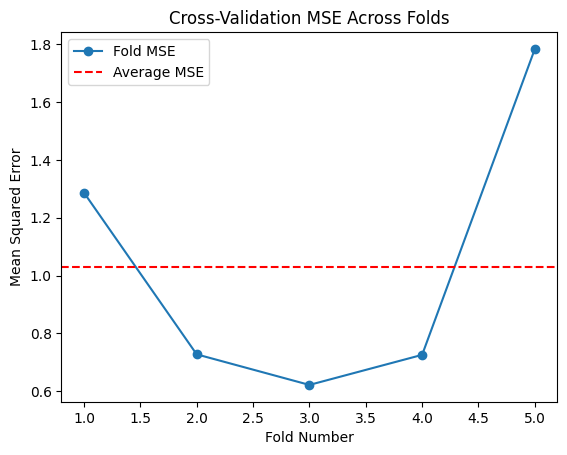

True Coefficients:
[ 0.96883694 -1.27818614 -1.11222093  0.79923699  1.17801727  1.81341931
 -0.76540041  0.19453434 -1.41274898 -0.25241936]
Bootstrap Standard Errors:
[0.08993547 0.09276057 0.0989198  0.1040557  0.1131802  0.09584016
 0.10442419 0.09343193 0.11287187 0.09534502]


In [1]:
# I began by importing the libraries I knew I would need for this analysis.
# These tools would help me create synthetic data, perform cross-validation, and analyze results.
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Step 1: Generating Synthetic Data
# I decided to generate synthetic data because I wanted complete control over the structure and size of the dataset.
# This would allow me to simulate a scenario similar to bioinformatics, where the dataset is small and high-dimensional.
np.random.seed(123)  # I set a seed for reproducibility because I wanted consistent results.
n_samples = 100  # I chose 100 samples to mimic a small dataset typical in bioinformatics.
n_features = 10  # I selected 10 predictors to demonstrate a high-dimensional feature space.

# I created predictors (X) using a standard normal distribution because this aligns with common assumptions.
X = np.random.normal(0, 1, size=(n_samples, n_features))

# I generated the true coefficients, which represent the "biological truth" underlying the data.
true_coefficients = np.random.uniform(-2, 2, size=n_features)

# I calculated the response variable (Y) by introducing a linear relationship with added Gaussian noise.
# The noise represents the inherent variability I often encounter in biological systems.
Y = np.dot(X, true_coefficients) + np.random.normal(0, 1, size=n_samples)

# I converted the dataset into a DataFrame for easier handling and visualization.
data = pd.DataFrame(X, columns=[f"X{i+1}" for i in range(n_features)])
data['Y'] = Y

# Step 2: Splitting the Data
# I needed to split the data into training and test sets so I could evaluate how well my model generalizes.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

# Step 3: Validation-Set Approach
# I started with a validation-set approach because it was straightforward and gave me an initial estimate of model performance.
model = LinearRegression()
model.fit(X_train, Y_train)  # I trained the model on the training set.
Y_val_pred = model.predict(X_test)  # I then made predictions on the validation set.

# I calculated the Mean Squared Error (MSE) for the validation set because I wanted a measure of model performance.
val_mse = mean_squared_error(Y_test, Y_val_pred)
print(f"Validation MSE: {val_mse:.4f}")
# While this approach was simple, I realized it had limitations due to high variability caused by the random split.

# Step 4: Implementing K-Fold Cross-Validation
# To overcome the drawbacks of the validation-set approach, I decided to use K-fold cross-validation.
# This method would allow me to make better use of the data and provide a more reliable estimate of test error.

# I set the number of folds to 5 because this was a good balance between computational efficiency and reliable error estimation.
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=123)

# I initialized an empty list to store the MSE for each fold.
cv_mse_scores = []

# I performed K-fold cross-validation by iterating through the splits.
for train_index, val_index in kf.split(X):
    # For each fold, I split the data into training and validation sets.
    X_train_cv, X_val_cv = X[train_index], X[val_index]
    Y_train_cv, Y_val_cv = Y[train_index], Y[val_index]

    # I trained the model on the training data for the current fold.
    model.fit(X_train_cv, Y_train_cv)

    # I made predictions on the validation set.
    Y_val_cv_pred = model.predict(X_val_cv)

    # I calculated the MSE for this fold and added it to my list.
    fold_mse = mean_squared_error(Y_val_cv, Y_val_cv_pred)
    cv_mse_scores.append(fold_mse)

# I calculated the average MSE across all folds because I wanted a single measure of test error.
avg_cv_mse = np.mean(cv_mse_scores)
print(f"Cross-Validation MSE (average across {k} folds): {avg_cv_mse:.4f}")

# Step 5: Visualizing Cross-Validation Results
# I decided to plot the MSE for each fold to see how the error varied across folds.
plt.plot(range(1, k + 1), cv_mse_scores, marker='o', linestyle='-', label="Fold MSE")
plt.axhline(y=avg_cv_mse, color='red', linestyle='--', label="Average MSE")
plt.xlabel("Fold Number")
plt.ylabel("Mean Squared Error")
plt.title("Cross-Validation MSE Across Folds")
plt.legend()
plt.show()

# Step 6: Bootstrap Method
# Since I wanted to estimate the variability of my coefficient estimates, I decided to use the bootstrap method.
n_bootstrap = 1000  # I chose 1000 resamples to get stable estimates of standard error.
bootstrap_coefficients = np.zeros((n_bootstrap, n_features))

# I performed the bootstrap procedure by resampling the data with replacement.
for i in range(n_bootstrap):
    # For each iteration, I sampled indices with replacement.
    bootstrap_indices = np.random.choice(range(n_samples), size=n_samples, replace=True)
    X_bootstrap = X[bootstrap_indices]
    Y_bootstrap = Y[bootstrap_indices]

    # I trained the model on the bootstrap sample.
    model.fit(X_bootstrap, Y_bootstrap)

    # I stored the coefficients from this bootstrap sample.
    bootstrap_coefficients[i, :] = model.coef_

# I calculated the standard error for each coefficient.
bootstrap_se = np.std(bootstrap_coefficients, axis=0)

# Step 7: Interpreting Results
# I wanted to compare the true coefficients with their estimated standard errors.
print("True Coefficients:")
print(true_coefficients)
print("Bootstrap Standard Errors:")
print(bootstrap_se)

# Summary:
# - K-fold cross-validation helped me estimate test error more reliably compared to the validation-set approach.
# - The bootstrap method allowed me to quantify the variability in coefficient estimates, which is critical for understanding model stability.
# - By using these methods, I felt confident that my model would generalize well to new data and that I understood the uncertainty in my estimates.
